In [1]:
import requests
import pandas as pd
import json
import numpy as np
import os
from datetime import timedelta
from kloppy import skillcorner
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from urllib.request import urlopen
from highlight_text import fig_text

from PIL import Image

from mplsoccer import PyPizza, add_image, FontManager


# Setup pitch and plot
from mplsoccer import Pitch
#from mplsoccer.pitch import Pitch ,VerticalPitch

# username = "XXX"
# password = "XXX"


# from skillcorner.client import SkillcornerClient
# client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')


In [2]:
def load_matches(matches_json_path):

    with open(matches_json_path, "r") as f:
        matches_json = json.load(f)

    match_ids = [match["id"] for match in matches_json]

    all_tracking = []

    for match_id in match_ids:
        tracking_data_github_url = f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl'
        
        dataset = skillcorner.load(
            meta_data=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json',
            raw_data=tracking_data_github_url,
            # Optional arguments,
            coordinates="skillcorner",
            include_empty_frames=False)

        all_tracking.append(dataset)

    all_de_dfs = []

    for match_id in match_ids:
        url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv"
        try:
            de_match = pd.read_csv(url)
            all_de_dfs.append(de_match)
        except Exception as e:
            print(f"Failed to load dynamic events for match {match_id}: {e}")

    de_all_matches = pd.concat(all_de_dfs, ignore_index=True)
    
    return all_tracking, de_all_matches
        

In [3]:
# Load matches

matches_json_path = os.path.join(os.path.dirname(os.getcwd()), "data/matches.json")
all_tracking, de_all_matches = load_matches(matches_json_path)

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_16164\822448290.py:27: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)
C:\Users\g4a4b\AppData\Local\Temp\ipykernel_16164\822448290.py:27: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)


In [4]:
# ------------- OFF-BALL RUN EVENTS ANALYSIS ---------------------

def untargeted_percentage(de_all_matches, all_tracking):

    # Get off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]
    print(f"Number of off-ball events: {off_ball_events.shape[0]}")

    # Get the total minutes played per match and sum across all matches
    total_duration = timedelta(0)
    for dataset in all_tracking:
        for period in dataset.metadata.periods:
            period_duration = period.end_timestamp - period.start_timestamp
            total_duration += period_duration
    print(f"Total played: {total_duration.total_seconds()/60:.1f} minutes")
    total_minutes = total_duration.total_seconds() / 60

    # Group by event_subtype
    off_ball_events_grouped = off_ball_events.groupby("event_subtype")

    # Calculate stats per each subtype
    off_ball_event_summary = []
    for subtype, group in off_ball_events_grouped:
        targeted_count = group["targeted"].sum()
        total_count = group.shape[0]
        untargeted_count = total_count - targeted_count
        # per90 scaled values
        total_per90 = (total_count * (90 / total_minutes))
        untargeted_per90 = (untargeted_count * (90 / total_minutes))
        untargeted_proportion = untargeted_count / total_count if total_count > 0 else 0
        print(f"Subtype: {subtype} Total: {total_count} ({total_per90:.2f}/90min), Untargeted: {untargeted_count} ({untargeted_per90:.2f}/90min, {untargeted_proportion:.2%})")
        # Save these values for later use
        off_ball_event_summary.append({
            "subtype": subtype,
            "total": total_count,
            "total_per90": total_per90,
            "untargeted": untargeted_count,
            "untargeted_per90": untargeted_per90,
            "untargeted_proportion": untargeted_proportion
        })

    # Convert to DataFrame for easier handling
    off_ball_event_stats_df = pd.DataFrame(off_ball_event_summary)

    # Get the overall stats too
    overall_total_count = off_ball_events.shape[0]
    overall_targeted_count = off_ball_events["targeted"].sum()
    overall_untargeted_count = overall_total_count - overall_targeted_count
    totalper90 = (overall_total_count * (90 / total_minutes))
    untargetedper90 = (overall_untargeted_count * (90 / total_minutes))
    untargetedproportion = overall_untargeted_count / overall_total_count if overall_total_count > 0 else 0
    print(f"Overall Off-Ball Events - Total: {overall_total_count} ({totalper90:.2f}/90min), Untargeted: {overall_untargeted_count} ({untargetedper90:.2f}/90min, {untargetedproportion:.2%})")

    return off_ball_event_stats_df

In [16]:
# Calculate percentage of untargeted off-ball runs by subtype

untargeted_percentage_df = untargeted_percentage(de_all_matches, all_tracking)

Number of off-ball events: 5002
Total played: 985.6 minutes
Subtype: behind Total: 363 (33.15/90min), Untargeted: 208 (18.99/90min, 57.30%)
Subtype: coming_short Total: 701 (64.01/90min), Untargeted: 457 (41.73/90min, 65.19%)
Subtype: cross_receiver Total: 423 (38.63/90min), Untargeted: 293 (26.76/90min, 69.27%)
Subtype: dropping_off Total: 631 (57.62/90min), Untargeted: 386 (35.25/90min, 61.17%)
Subtype: overlap Total: 153 (13.97/90min), Untargeted: 93 (8.49/90min, 60.78%)
Subtype: pulling_half_space Total: 148 (13.52/90min), Untargeted: 113 (10.32/90min, 76.35%)
Subtype: pulling_wide Total: 344 (31.41/90min), Untargeted: 190 (17.35/90min, 55.23%)
Subtype: run_ahead_of_the_ball Total: 1378 (125.84/90min), Untargeted: 903 (82.46/90min, 65.53%)
Subtype: support Total: 751 (68.58/90min), Untargeted: 525 (47.94/90min, 69.91%)
Subtype: underlap Total: 110 (10.05/90min), Untargeted: 78 (7.12/90min, 70.91%)
Overall Off-Ball Events - Total: 5002 (456.78/90min), Untargeted: 3246 (296.42/90min,

In [6]:
def plot_untargeted_percentage(untargeted_percentage_df, subtype_names_map=None):
    # Copy and sort
    df_plot = untargeted_percentage_df.copy()
    df_plot = df_plot.sort_values("untargeted_proportion", ascending=True)

    if subtype_names_map:
        df_plot["subtype_display"] = df_plot["subtype"].map(subtype_names_map)
    else:
        df_plot["subtype_display"] = df_plot["subtype"]

    plt.figure(figsize=(10, 6))

    # Draw bars with contour (edge)
    plt.barh(
        df_plot["subtype_display"],
        df_plot["untargeted_proportion"],
        color="#00ff1e",
        edgecolor="black",   # contour around each bar
        linewidth=1.5
    )

    # Title and axis labels
    plt.title("Share of Untargeted Runs by Run Type", fontsize=14, fontweight='bold', fontname='Arial')
    plt.xlabel("% untargeted", fontsize=12, fontweight='bold', fontname='Arial')
    plt.ylabel("Run Type", fontsize=12, fontweight='bold', fontname='Arial')

    # Format x-axis as percentages
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    # Remove all spines except left and bottom
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Remove grid
    plt.grid(False)

    # Y-axis tick labels
    plt.yticks(fontsize=12, fontweight='normal', fontname='Arial')

    plt.xlim(0, 1.0)
    plt.tight_layout()
    plt.show()

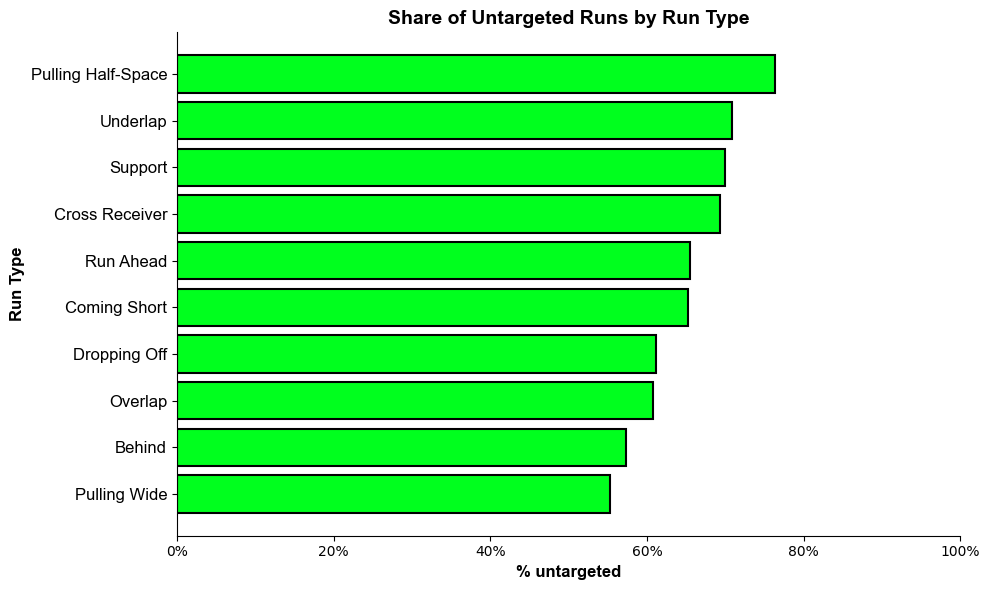

In [7]:
subtype_names_map = {
        "behind": "Behind",
        "coming_short": "Coming Short",
        "cross_receiver": "Cross Receiver",
        "dropping_off": "Dropping Off",
        "overlap": "Overlap",
        "pulling_half_space": "Pulling Half-Space",
        "pulling_wide": "Pulling Wide",
        "run_ahead_of_the_ball": "Run Ahead",
        "support": "Support",
        "underlap": "Underlap"
    }
plot_untargeted_percentage(untargeted_percentage_df, subtype_names_map=subtype_names_map)

In [10]:
def untargeted_runs_team_subtype(de_all_matches, all_tracking):
    # Get untargeted off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]
    untargeted_off_ball_events = off_ball_events[off_ball_events["targeted"] == False]

    # Group untargeted off-ball events by team and subtype
    team_subtype = untargeted_off_ball_events.groupby(
        ['team_id', 'team_shortname', 'event_subtype']).size().reset_index(name='untargeted_count')

    # Dictionary to store total minutes per team
    team_minutes = {}
    for dataset in all_tracking:
        match_duration = timedelta(0)
        for period in dataset.metadata.periods:
            period_duration = period.end_timestamp - period.start_timestamp
            match_duration += period_duration
        match_minutes = match_duration.total_seconds() / 60
        for team in dataset.metadata.teams:
            if team.team_id not in team_minutes:
                team_minutes[team.team_id] = 0
            team_minutes[team.team_id] += match_minutes

    # Merge total minutes into team_subtype DataFrame
    team_subtype['total_minutes'] = team_subtype['team_id'].map(team_minutes)
    
    # Calculate untargeted per90
    team_subtype['untargeted_per90'] = team_subtype['untargeted_count'] / team_subtype['total_minutes'] * 90

    # Pivot the DataFrame to have subtypes as columns and teams as rows
    df_pivot = team_subtype.pivot(
        index='team_shortname', 
        columns='event_subtype', 
        values='untargeted_per90'
        ).fillna(0)

    percentile_df = df_pivot.rank(pct=True) * 100
    
    return df_pivot, percentile_df


In [126]:
df_pivot, percentile_df = untargeted_runs_team_subtype(de_all_matches, all_tracking)

In [173]:
def individual_pizza_plot(df_pivot, percentile_df, team1, subtype_names_map, badges_dict=None):
    # Function to create pizza plot for a given team

    values = percentile_df.loc[team1].tolist() # percentile values for slices
    values = [round(v, 1) for v in values] # round to 1 decimal
    # absolute per90 for labels
    per90_values = df_pivot.loc[team1].tolist()
    # params is equal to the subtype names mapped, an intro and the absolute per90 values
    params = [subtype_names_map[subtype] for subtype in percentile_df.columns]

    slice_colors = ["#1A78CF"] * 2 + ["#FF9300"] * 3 + ["#D70232"] * 5
    text_colors = ["#000000"] * 5 + ["#F2F2F2"] * 5

    baker = PyPizza(
    params=params,                  # list of parameters
    straight_line_color="#F2F2F2",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-.",           # linestyle for other circles
    inner_circle_size=8,            # size of inner circle
    )

    # plot pizza
    fig, ax = baker.make_pizza(
            values,              # list of values
            figsize=(10, 10),      # adjust figsize according to your need
            param_location=110,  # where the parameters will be added
            slice_colors=slice_colors,       # color for individual slices
            value_colors=text_colors,        # color for the value-text
            value_bck_colors=slice_colors,   # color for the blank spaces
            kwargs_slices=dict(
                facecolor="cornflowerblue", edgecolor="black",
                zorder=2, linewidth=1
            ),                   # values to be used when plotting slices
            kwargs_params=dict(
                color="#000000", fontsize=10,
                fontproperties=font_normal.prop, va="center"
            ),                   # values to be used when adding parameter
            kwargs_values=dict(
            color="#000000", fontsize=10,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
                )                   
            )                   # values to be used when adding values            
        )
    # add title
    fig_text(
            0.515, 1,
            f"<{team1}> - Untargeted Runs Profile",
            size=15, fig=fig,
            highlight_textprops=[{"color": "#000000"}],
            ha="center", fontproperties=font_bold.prop, color="#000000"
    )
    
    # add image if badges_dict is provided
    if badges_dict and team1 in badges_dict:
        img = Image.open(badges_dict[team1])
        ax_image = add_image(
            img, fig, left=0.1, bottom=0.9, width=0.13, height=0.127
        )   # these values might differ when you are plotting
    
    # add subtitle
    fig.text(
    0.515, 0.94,
    "Percentile Rank vs A-league teams | Season 2024-25\n",
    size=12,
    ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add text
    fig.text(
        0.39, 0.935, "Direct        Progression       Build up", size=12,
        fontproperties=font_bold.prop, color="#000000"
    )

    # add rectangles
    fig.patches.extend([
        plt.Rectangle(
            (0.37, 0.935), 0.01, 0.01, fill=True, color="#1a78cf",
            transform=fig.transFigure, figure=fig
        ),
        plt.Rectangle(
            (0.45, 0.935), 0.01, 0.01, fill=True, color="#ff9300",
            transform=fig.transFigure, figure=fig
        ),
        plt.Rectangle(
            (0.575, 0.935), 0.01, 0.01, fill=True, color="#d70232",
            transform=fig.transFigure, figure=fig
        ),
    ])

    plt.show()
    

In [182]:
def comparing_pizza_plot(df_pivot, percentile_df, team1, team2, subtype_names_map, badges_dict=None):
    # Function to create pizza plot for a given team

    values = percentile_df.loc[team1].tolist() # percentile values for slices
    values = [round(v, 1) for v in values] # round to 1 decimal
    # absolute per90 for labels
    per90_values = df_pivot.loc[team1].tolist()
    # params is equal to the subtype names mapped, an intro and the absolute per90 values
    params = [subtype_names_map[subtype] for subtype in percentile_df.columns]

    if team2:
        values2 = percentile_df.loc[team2].tolist() # percentile values for slices
        values2 = [round(v, 1) for v in values2] # round

    slice_colors = ["#1A78CF"] * 2 + ["#FF9300"] * 3 + ["#D70232"] * 5
    text_colors = ["#000000"] * 5 + ["#F2F2F2"] * 5

    baker = PyPizza(
    params=params,                  # list of parameters
    straight_line_color="#F2F2F2",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-.",           # linestyle for other circles
    inner_circle_size=8,            # size of inner circle
    )


    # plot pizza
    fig, ax = baker.make_pizza(
            values,              # list of values
            figsize=(10, 10),      # adjust figsize according to your need
            compare_values=values2,  # list of values for comparison
            param_location=110,  # where the parameters will be added
            kwargs_slices=dict(
                facecolor="cornflowerblue", edgecolor="black",
                zorder=2, linewidth=1
            ),                   # values to be used when plotting slices
            kwargs_compare=dict(
                facecolor="#FF9300", edgecolor="#222222",
                zorder=2, linewidth=1,
            ),                   # values to be used when plotting comparison slices
            kwargs_params=dict(
                color="#000000", fontsize=10,
                fontproperties=font_normal.prop, va="center"
            ),                   # values to be used when adding parameter
            kwargs_values=dict(
            color="#000000", fontsize=10,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
                )                   
            ),                   # values to be used when adding values
            kwargs_compare_values=dict(
        color="#000000", fontsize=10, fontproperties=font_normal.prop, zorder=3,
        bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
            )
        )

    # add title
    fig_text(
            0.515, 1,
            f"<{team1}> vs <{team2}>",
            size=15, fig=fig,
            highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
            ha="center", fontproperties=font_bold.prop, color="#000000"
        )

    # add image for team2
    if badges_dict and team2 in badges_dict:
            img = Image.open(badges_dict[team2])
            ax_image = add_image(
                img, fig, left=0.8, bottom=0.9, width=0.13, height=0.127
            )   # these values might differ when you are plotting

    # add image if badges_dict is provided
    if badges_dict and team1 in badges_dict:
        img = Image.open(badges_dict[team1])
        ax_image = add_image(
            img, fig, left=0.1, bottom=0.9, width=0.13, height=0.127
        )   # these values might differ when you are plotting
    
    fig.text(
    0.515, 0.96,
    "Untargeted Runs Profile",
    size=13,
    ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    fig.text(
    0.515, 0.92,
    "Percentile Rank vs A-league teams | Season 2024-25\n",
    size=12,
    ha="center", fontproperties=font_bold.prop, color="#000000"
    )
    

    plt.show()

In [188]:
badges_folder = os.path.join(os.path.dirname(os.getcwd()), "badges")
badges_dict = {'Auckland FC': os.path.join(badges_folder, "AucklandFC.png"),
               'Brisbane FC': os.path.join(badges_folder, "BrisbaneFC.png")}

ordered_subtypes = [
    "cross_receiver",
    "behind",
    "run_ahead_of_the_ball",
    "overlap",
    "underlap",
    "support",
    "coming_short",
    "dropping_off",
    "pulling_half_space",
    "pulling_wide"
]

percentile_df = percentile_df[ordered_subtypes]
df_pivot = df_pivot[ordered_subtypes]

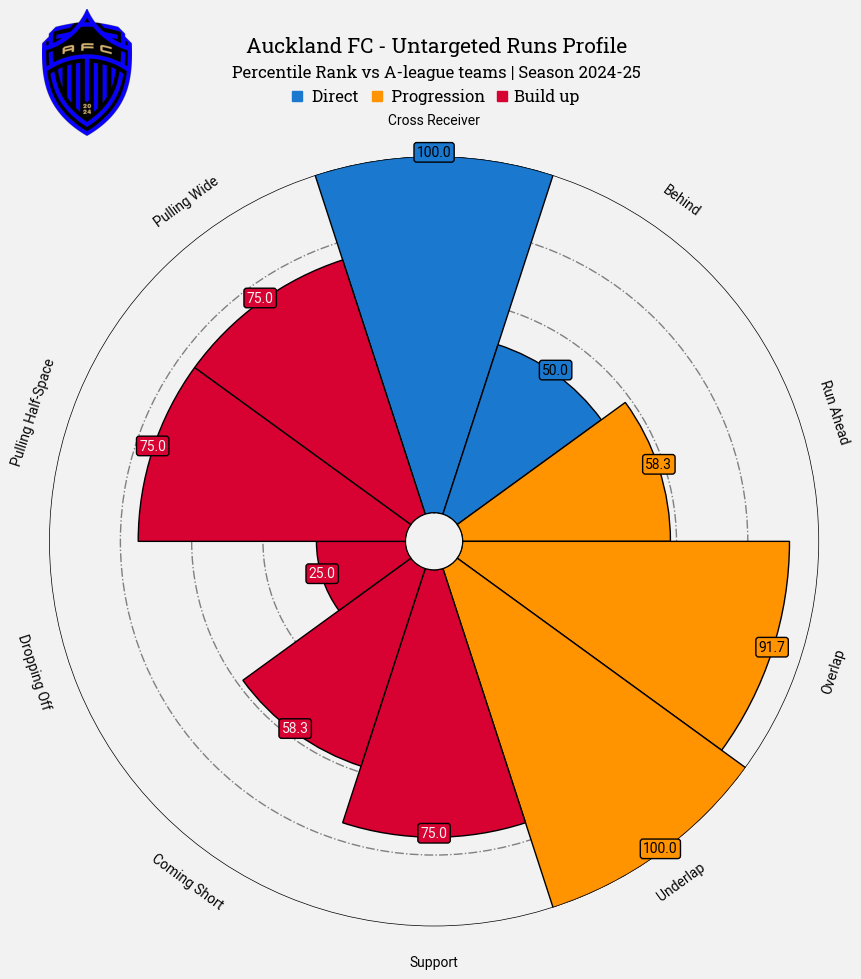

In [178]:
individual_pizza_plot(df_pivot, percentile_df,'Auckland FC', subtype_names_map=subtype_names_map, badges_dict=badges_dict)

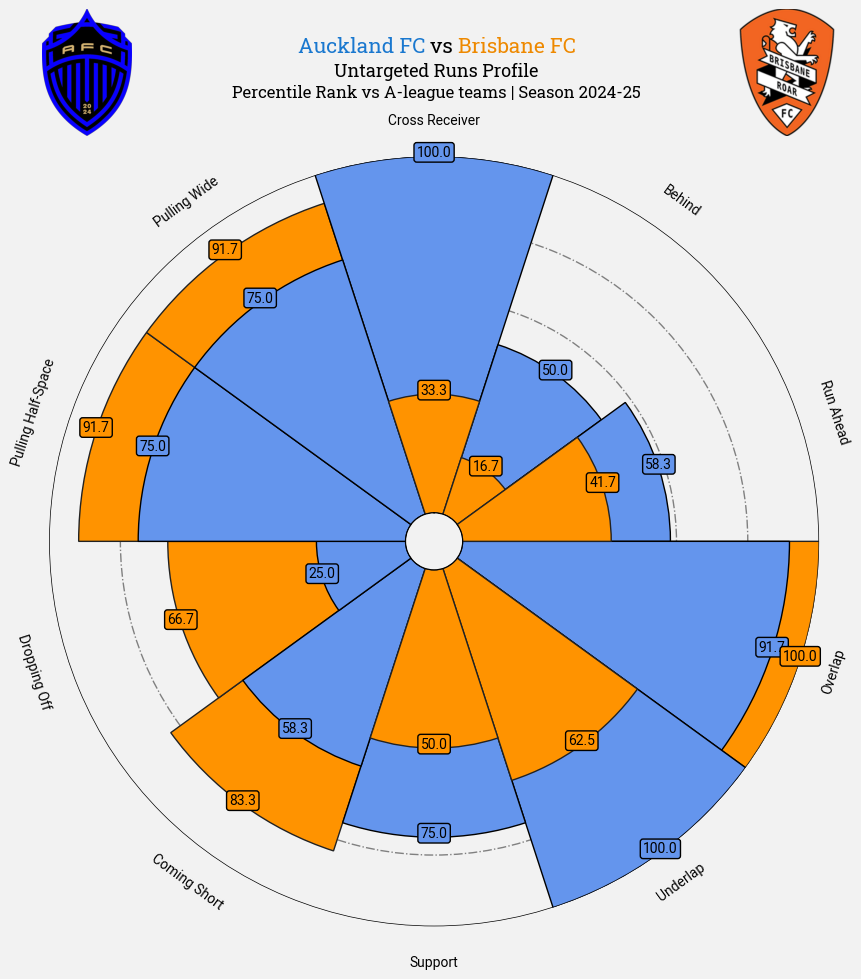

In [ ]:
comparing_pizza_plot(df_pivot, percentile_df,'Auckland FC', "Brisbane FC", subtype_names_map=subtype_names_map, badges_dict=badges_dict)

In [246]:
# Function to get the total number of untargeted off-ball runs per subtype per phase of play

def untargeted_runs_team_subtype_phase(de_all_matches, all_tracking):

    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]

    # Group by team_in_possession_phase_type and event_subtype
    off_ball_event_groups = off_ball_events.groupby(["team_in_possession_phase_type", "event_subtype"])

    # Calculate stats per each subtype
    off_ball_event_summary = []
    for (phase, subtype), group in off_ball_event_groups:
        targeted_count = group["targeted"].sum()
        total_count = group.shape[0]
        untargeted_count = total_count - targeted_count
        # Save these values for later use
        off_ball_event_summary.append({
            "phase": phase,
            "subtype": subtype,
            "untargeted": untargeted_count
        })

    # Convert to DataFrame for easier handling
    off_ball_event_stats_df = pd.DataFrame(off_ball_event_summary)

    return off_ball_event_stats_df 

In [247]:
subtype_phase_df = untargeted_runs_team_subtype_phase(de_all_matches, all_tracking)

In [ ]:
def untargeted_bubble_plot(df_plot, ordered_subtypes, phase_order=None, phase_names_map=None, subtype_names_map=None):

    # Default orders if not provided
    if ordered_subtypes is None:
        ordered_subtypes = df_plot['subtype'].unique().tolist()
    if phase_order is None:
        phase_order = df_plot['phase'].unique().tolist()

    # Pivot table to get untargeted counts
    df_pivot = df_plot.pivot_table(
        index='subtype', columns='phase', values='untargeted', fill_value=0
    )

    # Ensure consistent order
    df_pivot = df_pivot.reindex(index=ordered_subtypes, columns=phase_order)

    # Map phase and subtype names
    if phase_names_map:
        df_pivot.columns = [phase_names_map.get(col, col) for col in df_pivot.columns]
        phase_order = list(df_pivot.columns)  # update phase_order to mapped names
    if subtype_names_map:
        df_pivot.index = [subtype_names_map.get(idx, idx) for idx in df_pivot.index]
        ordered_subtypes = list(df_pivot.index)  # update ordered_subtypes to mapped names

    # Calculate percentages per phase
    df_percent = df_pivot.divide(df_pivot.sum(axis=0), axis=1) * 100

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor("#ffffff")

    for i, subtype in enumerate(df_percent.index):
        for j, phase in enumerate(df_percent.columns):
            pct = df_percent.loc[subtype, phase]
            if pct > 0:
                size = 100 + pct * 18  # bubble size scales with percentage
                alpha = 0.3 + 0.7 * (pct / 100)  # bigger alpha for bigger percentages
                ax.scatter(j, i, s=size, color="#00ff1e", alpha=alpha, edgecolors="black", linewidth=0.8)

                if pct > 10:  # show text only if percentage >10%
                    font_w = 'bold' if pct >= 25 else 'normal'
                    text_size = 5 + pct / 10
                    ax.text(j, i, f"{pct:.0f}%", ha='center', va='center',
                            fontsize=text_size, fontweight=font_w, fontname='Arial')

    # Axis settings
    ax.set_xticks(range(len(phase_order)))
    ax.set_xticklabels(phase_order, rotation=45, ha='right', fontsize=12, fontweight='normal', fontname='Arial')
    ax.set_yticks(range(len(ordered_subtypes)))
    ax.set_yticklabels(ordered_subtypes, fontsize=12, fontweight='normal', fontname='Arial')

    # Invert y-axis to show first subtype at the top
    ax.invert_yaxis()

    # Remove top, right, bottom spines, keep only left y-axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)

    ax.set_xlabel("Phase", fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_ylabel("Run type", fontsize=12, fontweight='bold', fontname='Arial')

    ax.set_title('Untargeted Runs by Run Type and Phase', fontsize=14, fontweight='bold', fontname='Arial', pad=20)

    plt.tight_layout()
    plt.show()


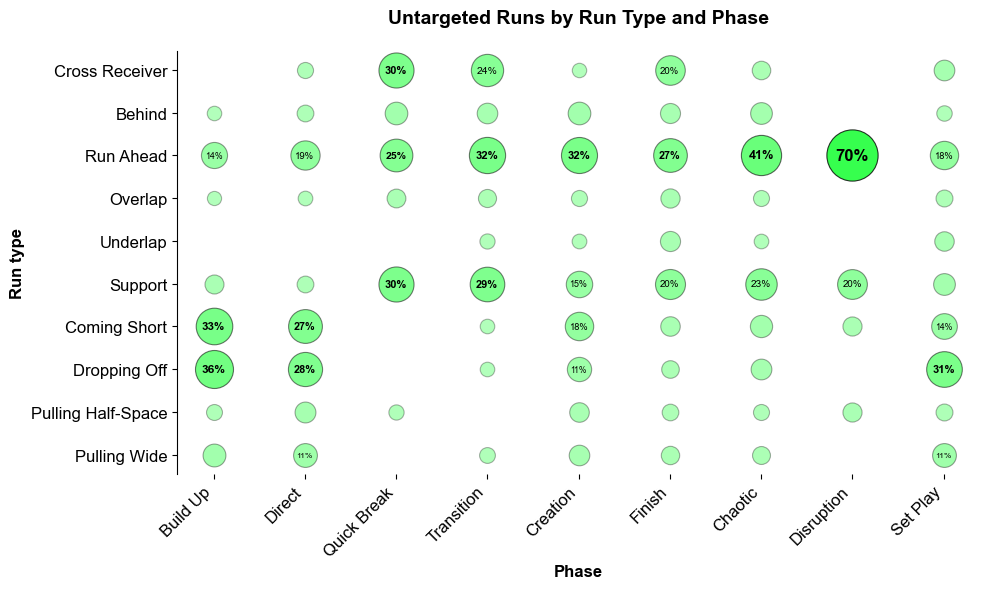

In [269]:
phase_map = {
    "build_up": "Build Up",
    "direct": "Direct",
    "quick_break": "Quick Break",
    "transition": "Transition",
    "create": "Creation",
    "finish": "Finish",
    "chaotic": "Chaotic",
    "disruption": "Disruption",
    "set_play": "Set Play"
}

phase_order = [
    "build_up",
    "direct",
    "quick_break",
    "transition",
    "create",
    "finish",
    "chaotic",
    "disruption",
    "set_play"
]
untargeted_bubble_plot(subtype_phase_df, ordered_subtypes=ordered_subtypes, phase_order=phase_order, phase_names_map=phase_map, subtype_names_map=subtype_names_map)

In [ ]:
# Interested in time_start, time_end, end_type, lead_to_shot, lead_to_goal, received_in_space, targeted_passing_option_event_id, pass_outcome, pass_range_received, third_end, channel_end, team_shortname, n_simultaneous_runs,n_opponents_bypassed, n_passing_options_dangerous_not_difficult, n_passing_options_ahead, push_defensive_line

In [ ]:
# Percentage of untargeted runs that lead to a goal/shot/cross/ball in the penalty area/the ball progresses a lot without losing it within the next 5-10 seconds

def untargeted_run_outcomes(de_all_matches):

    # Get untargeted off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]
    untargeted_off_ball_events = off_ball_events[off_ball_events["targeted"] == False]

In [8]:
# Count how many False are in is_player_possession_start_matched and is_player_possession_end_matched
false_start_count = de_all_matches['is_player_possession_start_matched'].value_counts().get(False, 0)
false_end_count = de_all_matches['is_player_possession_end_matched'].value_counts().get(False, 0)
print(f"Number of events: {de_all_matches.shape[0]}")
print(f"Number of events with unmatched start possession: {false_start_count}")
print(f"Number of events with unmatched end possession: {false_end_count}")


Number of events: 47853
Number of events with unmatched start possession: 1185
Number of events with unmatched end possession: 1526


In [27]:
def push_defensive_line_analysis(de_all_matches):
    # Get untargeted off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]
    untargeted_off_ball_events = off_ball_events[off_ball_events["targeted"] == False]
    in_behind_runs = untargeted_off_ball_events[untargeted_off_ball_events["event_subtype"] == "behind"]

    # Filter for push_defensive_line == True
    push_dl_events = in_behind_runs[in_behind_runs["push_defensive_line"] == True]

    total_behind = in_behind_runs.shape[0]
    total_push_dl = push_dl_events.shape[0]

    proportion_push_dl = total_push_dl / total_behind if total_behind > 0 else 0

    print(f"Total untargeted off-ball runs of subtype 'behind': {total_behind}")
    print(f"Total untargeted off-ball runs of subtype 'behind' that pushed defensive line: {total_push_dl}")
    print(f"Proportion of untargeted off-ball runs of subtype 'behind' that pushed defensive line: {proportion_push_dl:.2%}")
    
    return proportion_push_dl

In [28]:
push_dl_proportion = push_defensive_line_analysis(de_all_matches)

Total untargeted off-ball runs of subtype 'behind': 208
Total untargeted off-ball runs of subtype 'behind' that pushed defensive line: 77
Proportion of untargeted off-ball runs of subtype 'behind' that pushed defensive line: 37.02%


In [92]:
def add_possession_info_to_off_ball(de_all_matches):
    # 1. Filter untargeted off-ball runs
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]
    untargeted_off_ball = off_ball_events[off_ball_events["targeted"] == False].copy()
    
    # 2. Filter only possession events (keep only relevant columns)
    possession_cols = [
        "match_id", "event_id",
        "lead_to_different_phase",
        "team_possession_loss_in_phase",
        "team_in_possession_phase_type",
        "current_team_in_possession_next_phase_type"
    ]
    possession_events = de_all_matches[de_all_matches["event_type_id"] == 8][possession_cols].copy()
    
    # 3. Create composite keys (match_id + event_id)
    untargeted_off_ball["id"] = (
        untargeted_off_ball["match_id"].astype(str) + "_" +
        untargeted_off_ball["associated_player_possession_event_id"].astype(str)
    )
    possession_events["id"] = (
        possession_events["match_id"].astype(str) + "_" +
        possession_events["event_id"].astype(str)
    )
    
    # 4. Map possession attributes to off-ball runs
    for col in ["lead_to_different_phase",
                "team_possession_loss_in_phase",
                "team_in_possession_phase_type",
                "current_team_in_possession_next_phase_type"]:
        untargeted_off_ball[col] = untargeted_off_ball["id"].map(
            possession_events.set_index("id")[col]
        )

    # Excluding type of runs where the n of untargetd runs per90 is less than 15. We exclude "overlap", "underlap", "pulling_half_space"
    not_valid_subtypes = ["overlap", "underlap", "pulling_half_space"]
    untargeted_off_ball = untargeted_off_ball[~untargeted_off_ball["event_subtype"].isin(not_valid_subtypes)]
    print(f"Number of untargeted off-ball events: {len(untargeted_off_ball)}")

    # lead_to_different_phase equals True and team_possession_loss_in_phase equals False
    condition = (untargeted_off_ball["lead_to_different_phase"] == True) & (untargeted_off_ball["team_possession_loss_in_phase"] == False)
    leads_to_change = untargeted_off_ball[condition]
    print(f"Number of untargeted off-ball events (of specific subtypes) leading to different phase without possession loss: {len(leads_to_change)}")

    # Count of each subtype leading to phase change
    subtype_counts = leads_to_change["event_subtype"].value_counts()

    # Convert to proportion of the total leads_to_change
    sizes = subtype_counts / subtype_counts.sum()  # This sums to 1
    labels = subtype_counts.index.tolist()

    # Overall percentage
    total_percentage = len(leads_to_change) / len(untargeted_off_ball) * 100
    print(f"Overall percentage of untargeted off-ball runs (of specific subtypes) leading to different phase without possession loss: {total_percentage:.2f}%")

    return sizes, labels, total_percentage

def plot_donut(sizes, labels, total_percentage, subtype_names_map = None):
    """
    Draws a donut plot with overall percentage in the center.
    """
    if subtype_names_map:
        labels = [subtype_names_map.get(label, label) for label in labels]
    # Create the donut

    fig, ax = plt.subplots(figsize=(7,7))
    wedges, texts, autotexts = ax.pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%',
        pctdistance=0.85,
        startangle=90,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white', 'alpha':0.65}
    )

    for text in texts + autotexts:
        text.set_fontname('Arial')  # normal
        text.set_fontsize(11)

    # Add center circle
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)

    # Add the total percentage in the center
    plt.text(0, 0, f'{total_percentage:.1f}%', horizontalalignment='center', 
             verticalalignment='center', fontsize=20, fontweight='bold', fontname='Arial')
    
    annotation_lines = [
    "Types of Untargeted off-ball runs with",
    "less than 15 runs per90min are excluded"
    ]

    for i, line in enumerate(annotation_lines):
        plt.text(
            0.8, 0.025 - i*0.025,  # move each line down by fixed step
            line,
            va='bottom',
            fontsize=8,
            fontname='Arial',
            color='gray',
            transform=ax.transAxes
        )

    ax.set_title("% of Untargeted off-ball runs leading to a phase change", fontsize=16, fontweight='bold', fontname='Arial')
    plt.show()


Number of untargeted off-ball events: 2962
Number of untargeted off-ball events (of specific subtypes) leading to different phase without possession loss: 708
Overall percentage of untargeted off-ball runs (of specific subtypes) leading to different phase without possession loss: 23.90%


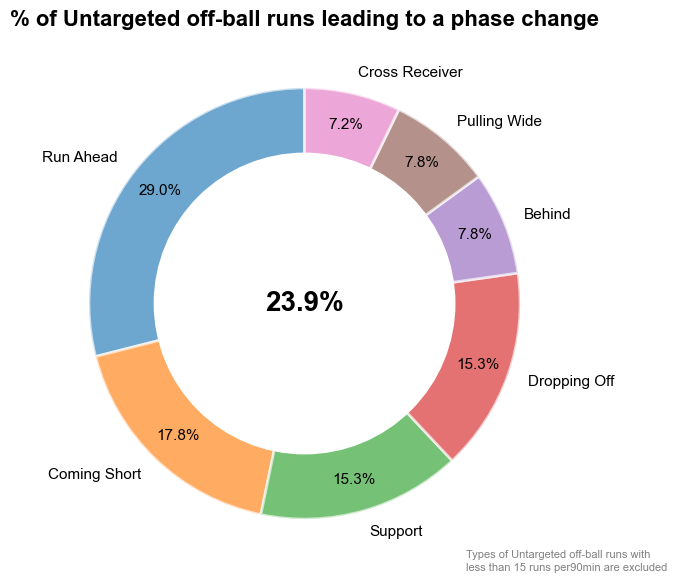

In [93]:
sizes, labels, total_percentage = add_possession_info_to_off_ball(de_all_matches)
plot_donut(sizes, labels, total_percentage, subtype_names_map=subtype_names_map)